In [1]:
import pandas as pd
import glob


First, we define a design matrix for the model.
As the model is trivial (one-sample test), the design matrix is just one column with ones.

In [3]:
data = glob.glob('/Volumes/QCI/ZY/zy_seedFC_all_data135/*.nii.gz')
second_level_input = data
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["intercept"],
)

Next, we specify and estimate the model.

In [4]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(
    second_level_input, design_matrix=design_matrix
)

Compute the only possible contrast: the one-sample test. Since there is only one possible contrast,
we don’t need to specify it in detail.

In [5]:
z_map = second_level_model.compute_contrast(output_type="z_score")

Threshold the resulting map without multiple comparisons correction, abs(z) > 3.29 (equivalent to p < 0.001), cluster size > 10 voxels.

In [7]:
from nilearn.image import threshold_img

threshold_img(
    z_map,
    threshold=3.29,
    cluster_threshold=10,
    two_sided=True,

)

This is equivalent to thresholding a z-statistic image with a false positive rate < .001, cluster size > 10 voxels.

In [9]:
from nilearn.glm import threshold_stats_img

thresholded_map1, threshold1 = threshold_stats_img(
    z_map,
    alpha=0.001,
    height_control="fpr",
    cluster_threshold=10,
    two_sided=True,
)

Now use FDR <.05 (False Discovery Rate) and no cluster-level threshold.

In [10]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr"
)
print(f"The FDR=.05 threshold is {threshold2:.3g}")

The FDR=.05 threshold is 2.09


Now use FWER <.05 (Family-Wise Error Rate) and no cluster-level threshold.
As the data has not been intensively smoothed, we can use a simple Bonferroni correction.

In [11]:
thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3:.3g}")

The p<.05 Bonferroni-corrected threshold is 5.15


First, the unthresholded map.

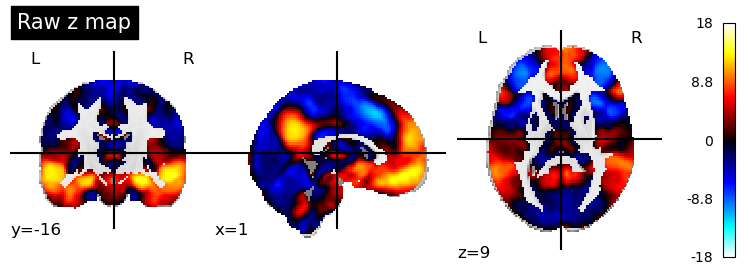

In [12]:
from nilearn import plotting

display = plotting.plot_stat_map(z_map, title="Raw z map")

Second, the p<.001 uncorrected-thresholded map (with only clusters > 10 voxels).

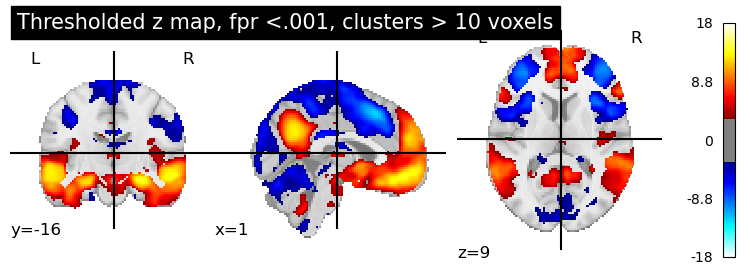

In [13]:
plotting.plot_stat_map(
    thresholded_map1,
    cut_coords=display.cut_coords,
    threshold=threshold1,
    title="Thresholded z map, fpr <.001, clusters > 10 voxels",
)

Third, the fdr-thresholded map.

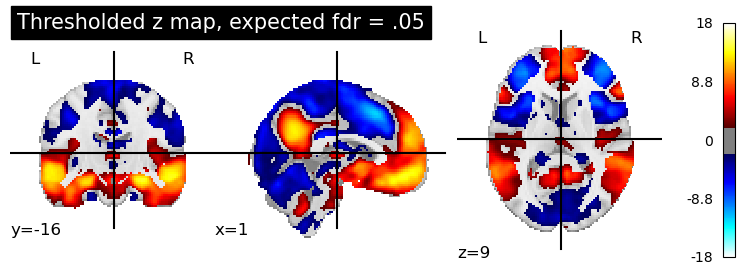

In [14]:
plotting.plot_stat_map(
    thresholded_map2,
    cut_coords=display.cut_coords,
    title="Thresholded z map, expected fdr = .05",
    threshold=threshold2,
)

Fourth, the Bonferroni-thresholded map.

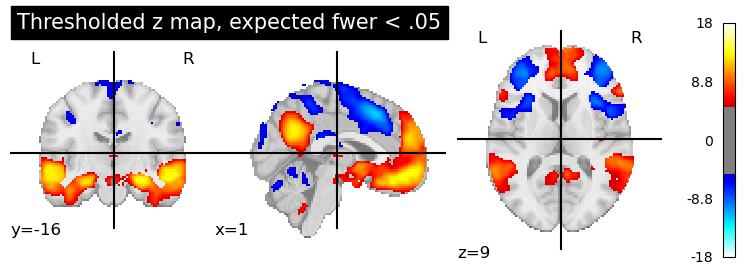

In [15]:
plotting.plot_stat_map(
    thresholded_map3,
    cut_coords=display.cut_coords,
    title="Thresholded z map, expected fwer < .05",
    threshold=threshold3,
)